# Neural Style Transfer

The objective of this notebook is to take an input image and transform it with artistic style.

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!pip install -q torch==1.5.0 torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 603.7MB 24kB/s 
     |████████████████████████████████| 6.5MB 2.1MB/s 


In [3]:
# Import necessary packages
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [4]:
GDRIVE_PATH = '/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/S7_NeuralTransfer_SRGAN/'

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imsize = 512 if torch.cuda.is_available() else 128

In [7]:
# Load style and content images and transform.
loader = transforms.Compose([
                             transforms.Resize((imsize, imsize)),
                             transforms.ToTensor()
                            ])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_image = image_loader('./monalisa.jpg')
content_image = image_loader('./dancing.jpg')

assert style_image.shape == content_image.shape, "please have the style and content of the same size"

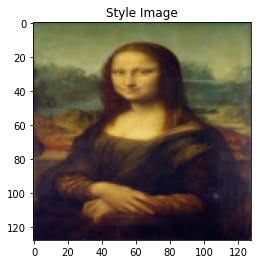

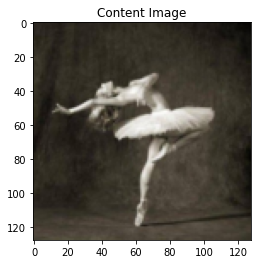

In [8]:
# display images
unloader = transforms.ToPILImage()

# Matplotlib in interactive mode
plt.ion()

# Make a copy of the tensor, put it on cpu, remove batch dim
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
imshow(style_image, title='Style Image')

plt.figure()
imshow(content_image, title='Content Image')

In [9]:
# Content Loss
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input # check this

In [10]:
# Gram matrix
def gram_matrix(input):
    a, b, c, d = input.size()

    features = input.view(a*b, c*d)
    # Matrix multiplication of features with its transpose
    G = torch.mm(features, features.t())
    # Normalize by dividing by total number of elements in the feature map and return.
    return G.div(a * b * c * d)

In [11]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


In [12]:
# Import pre-trained VGG19 model. Model contains 2 parts- features (convolution and pooling) and classifier(fully connected layers).
# Use features module to extract feature map for content and style loss.
# Model in eval mode to infer.
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [13]:
# Pre-trained model is trained on Imagenet dataset. Use Imagenet's stats to normalize image.
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Module to normalize images
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # View mean and std in [Cx1x1] format to work directly on images which are in NxCxHxW.
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)
    
    def forward(self, img):
        return (img - self.mean) / self.std

Pre-trained vgg model contains series of conv -> relu -> maxpool blocks. Layers for content and style loss needs to be inserted after every conv blocks. Hence, new module is created.

In [14]:
# Desired depths to calculate content/style losses.
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_image, content_image, 
                               content_layers = content_layers_default,
                               style_layers = style_layers_default):
    # Deep copy vgg model
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    # Collect metrics
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    # convolution counter
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        
        model.add_module(name, layer)

        # Add content loss
        if name in content_layers:
            target = model(content_image).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target = model(style_image).detach()
            style_loss = StyleLoss(target)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # Trim of layers after the last content or style loss layers.
    for i in range(len(model)-1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    
    model = model[:(i+1)]

    return model, style_losses, content_losses
    

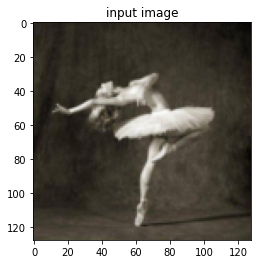

In [15]:
# Prepare input image. We can take the content image or create white noise image.
input_image = content_image.clone()
# input_image = torch.randn(content_image.shape, device=device)
plt.figure()
imshow(input_image, title="input image")

In [16]:
# Gradient descent using L-BFGS. Unlike training a network, we want to train the input image in order to minimise the content/style losses. 
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [17]:
# Function to perform the neural style transfer.
def run_style_transfer(cnn, normalization_mean, normalization_std, content_image, style_image, input_image, num_steps=300,
                       style_weight=500000, content_weight=1):
    print("Building the style transfer model...")
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_image, content_image)
    optimizer = get_input_optimizer(input_image)

    print("Optimizing...")
    run = [0]
    while run[0] < num_steps:

        def closure():
            input_image.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_image)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            
            for cl in content_losses:
                content_score += cl.loss
            
            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}".format(run))
                print("Style loss: {:4f}   Content loss: {:4f}".format(style_score.item(), content_score.item()))
                print()

            return style_score + content_score
        
        optimizer.step(closure)

    input_image.data.clamp_(0, 1)
    return input_image


Building the style transfer model...
Optimizing...
run [50]
Style loss: 29.501621   Content loss: 11.629265

run [100]
Style loss: 10.461592   Content loss: 11.209906

run [150]
Style loss: 6.075124   Content loss: 10.465265

run [200]
Style loss: 4.274187   Content loss: 10.054855

run [250]
Style loss: 3.446484   Content loss: 9.677332

run [300]
Style loss: 2.963869   Content loss: 9.403185



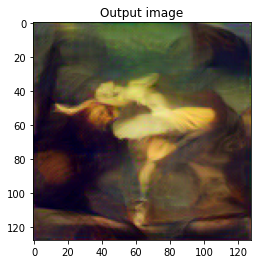

In [18]:
# Run model
output = run_style_transfer(cnn, normalization_mean, normalization_std, content_image, style_image, input_image)

plt.figure()
imshow(output, title="Output image")

plt.ioff()
plt.show()

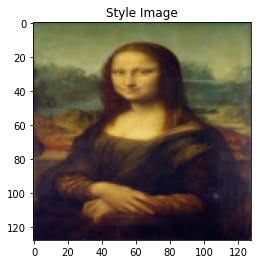

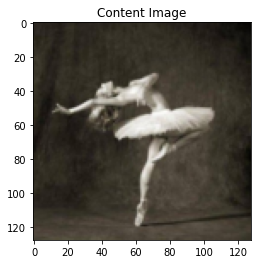

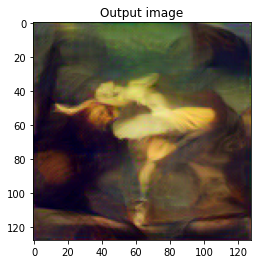

In [19]:
plt.figure()
imshow(style_image, title='Style Image')

plt.figure()
imshow(content_image, title='Content Image')

plt.figure()
imshow(output, title="Output image")